# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Описание данных

In [1]:
!pip install scikit-learn==1.1.3

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv('/datasets/autos.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [6]:
data.duplicated().sum()

4

In [7]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [8]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


В исходных данных можно увидеть несколько проблем: некорректный тип данных или эти признаки в целом не являются важными для определения стоимости автомобиля. Кроме этого, в таблице выявлено 4 дубликата (при общем количестве строк их удаление не исказит вычисления) и значительное количество пропусков в 4 признаках: VehicleType, Gearbox, Model, FuelType, Repaired.

Попробуем преобразовать данные для более корректной дальнейшей работы.

### Предобработка данных

In [9]:
data = data.drop(['DateCrawled', 'DateCreated', 'LastSeen', 'NumberOfPictures', 'PostalCode', 'RegistrationMonth'], axis = 1)
data = data.drop_duplicates()

In [10]:
data['Repaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

Можно предположить, что пропуски в столбце Repaired означают, что машина не была в ремонте. Поэтому заменим здесь пропуски на значение 'no'

In [11]:
data['Repaired'] = data['Repaired'].fillna('no', inplace=True)

In [12]:
data['FuelType'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [13]:
data['VehicleType'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

В признаках FuelType и VehicleType есть значение 'other'. Вероятнее, значения в строках с пропусками не подходили под основные типы топлива или автомобильного кузова. Поэтому здесь пропуски заменим на категорию 'other'.

In [14]:
data.fillna({'FuelType': 'other', 'VehicleType': 'other'}, inplace=True)

In [15]:
data['Gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [16]:
len(data['Model'].unique())

251

В столбцах Gearbox и Model нельзя сделать предположения о возможных значениях пропусков, удалить их также нельзя из-за большого количества. Заполним пропуски в этих признаках, подставив тип коробки передач - 'manual', а модель автоболия - 'unknown'. 

In [17]:
data.fillna({'Gearbox':'manual', 'Model':'unknown'}, inplace=True)

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 309329 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             309329 non-null  int64 
 1   VehicleType       309329 non-null  object
 2   RegistrationYear  309329 non-null  int64 
 3   Gearbox           309329 non-null  object
 4   Power             309329 non-null  int64 
 5   Model             309329 non-null  object
 6   Kilometer         309329 non-null  int64 
 7   FuelType          309329 non-null  object
 8   Brand             309329 non-null  object
 9   Repaired          0 non-null       object
dtypes: int64(4), object(6)
memory usage: 26.0+ MB


Данные обработаны. Далее необходимо обработать аномалии.

### Обработка аномалий

В столбцах Gearbox, Model, FuelType, VehicleType, Brand, Repaired аномалий при предобработке данных не выявлено. Рассмотрим остальные признаки.

In [19]:
print((sorted(data['RegistrationYear'].unique())))

[1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500, 1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000, 3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555, 5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200, 8455, 8500, 8888, 9000, 9229, 9450, 9996, 9999]


Удалим все странные значения и значения, где автомобиль был выпущен ранее 1980 года, так как по статистике автомобиль остается на ходу в течение 10-20 лет. Оставим промежуто +- 20 лет от 2000 года.

In [20]:
data = data[(data.RegistrationYear >= 1980) & (data.RegistrationYear <= 2020)]

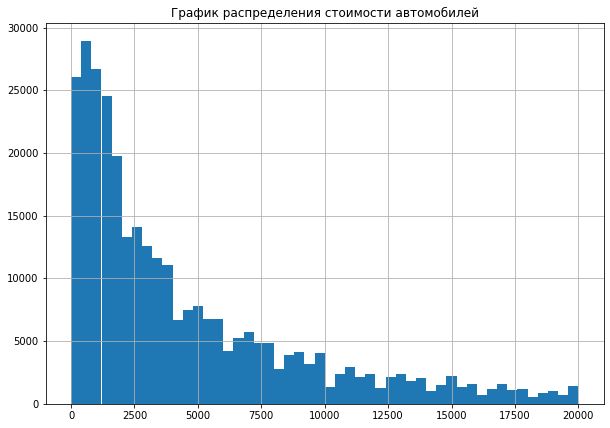

In [21]:
data['Price'].hist(bins=50,figsize=(10,7));
plt.title('График распределения стоимости автомобилей');

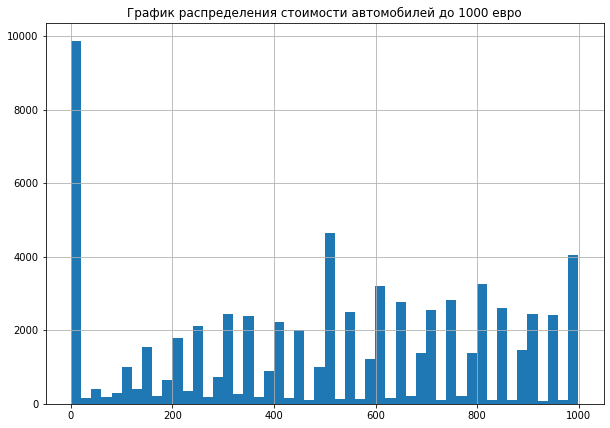

In [22]:
data.loc[data['Price']<1000]['Price'].hist(bins=50,figsize=(10,7));
plt.title('График распределения стоимости автомобилей до 1000 евро');

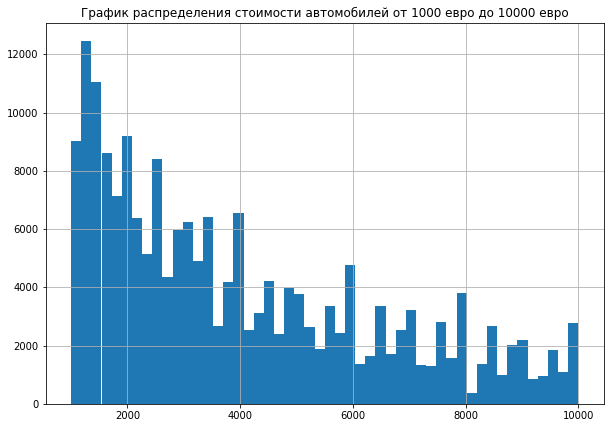

In [23]:
data.loc[(data['Price']>=1000) & (data['Price']<10000)]['Price'].hist(bins=50,figsize=(10,7));
plt.title('График распределения стоимости автомобилей от 1000 евро до 10000 евро');

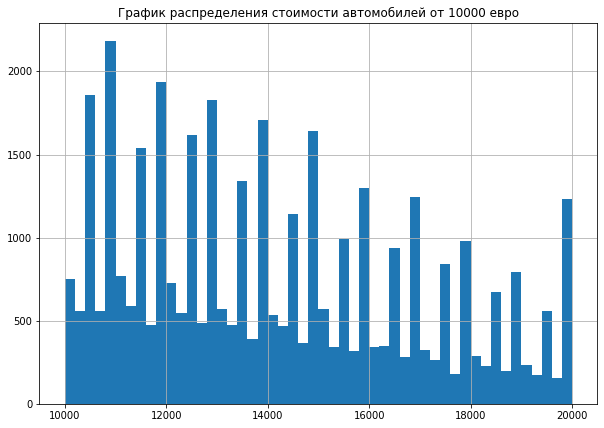

In [24]:
data.loc[data['Price']>=10000]['Price'].hist(bins=50,figsize=(10,7));
plt.title('График распределения стоимости автомобилей от 10000 евро');

По графикам можно сделать вывод:
- присутствуют очень маленькие цены на автомобили. По данным первый квантиль равен 1050 евро.

Оставим данные только в этой ценновой категории.

In [25]:
data = data[data.Price >= 1050]

In [26]:
print(sorted(data['Power'].unique()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222

По данным первый квантиль равен 69 л.с., что достаточно для очень простого автомобиля. При этом есть также значения, которые превышают существующие значения мощностей. В современном мире мощность в 500 л.с. является высоким показателем, не считая автомобили, предназначенные для особых целей. Поэтому здесь также оставим данные только в этом числовом промежутке. 

In [27]:
data = data[(data.Power >= 69) & (data.Power <= 500)]

In [28]:
print(sorted(data['Kilometer'].unique()))

[5000, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 125000, 150000]


Здесь, вероятнее, данные заполнялись по определенным категориям. Все значения входят в возможные значения пробега автомобиля. Поэтому этот признак оставим без изменений.

## Обучение моделей 

### Подготовка данных

Преобразуем категориальные признаки в числовые и разделим данные на выборки.

In [29]:
features = data.drop('Price', axis=1)
target = data['Price']
features_80, features_test, target_80, target_test = train_test_split(
    features, target, test_size=.2, random_state=12345)
features_train, features_valid, target_train, target_valid = train_test_split(
    features_80, target_80, test_size=.25, random_state=12345)
features_train.shape, target_train.shape, features_valid.shape, target_valid.shape, features_test.shape, target_test.shape

((115494, 9), (115494,), (38498, 9), (38498,), (38498, 9), (38498,))

In [30]:
ohe_features = features.select_dtypes(include='object').columns.to_list()

num_features = features_train.select_dtypes(exclude='object').columns.to_list()

X_train = features_train.copy()
X_test = features_test.copy()
X_valid = features_valid.copy()
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

encoder_ohe.fit(X_train[ohe_features])

X_train[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(X_train[ohe_features])

X_train = X_train.drop(ohe_features, axis=1)

scaler = StandardScaler()

X_train[num_features] = scaler.fit_transform(X_train[num_features])

X_test[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(X_test[ohe_features])

X_test = X_test.drop(ohe_features, axis=1)

X_test[num_features] = scaler.transform(
    X_test[num_features]
)

X_valid[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(X_valid[ohe_features])

X_valid = X_valid.drop(ohe_features, axis=1)

X_valid[num_features] = scaler.transform(
    X_valid[num_features]
)

In [31]:
columns = ['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'Repaired', 'Model']
X_train_encoder = features_train.copy()
X_test_encoder = features_test.copy()
X_valid_encoder = features_valid.copy()
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

encoder.fit(X_train_encoder[columns])
X_train_encoder[columns] = encoder.transform(X_train_encoder[columns])
X_train_encoder = X_train_encoder.drop(columns, axis=1)

X_test_encoder[columns] = encoder.transform(X_test_encoder[columns])
X_test_encoder = X_test_encoder.drop(columns, axis=1)

X_valid_encoder[columns] = encoder.transform(X_valid_encoder[columns])
X_valid_encoder = X_valid_encoder.drop(columns, axis=1)

### LinearRegression

In [32]:
%%time
model = LinearRegression()
model.fit(X_train, target_train)

CPU times: user 15.5 s, sys: 38.7 s, total: 54.2 s
Wall time: 54.5 s


LinearRegression()

In [33]:
%%time
predicted = model.predict(X_valid)
mse(predicted, target_valid)**0.5

CPU times: user 60 ms, sys: 97.3 ms, total: 157 ms
Wall time: 156 ms


2617.1782211786913

При использовании линейной регрессии показатель метрики RMSE 2617.1782211786913. При нашем ограничении в 2500 эта модель не подойдет для исследований.

### CatBoostRegressor

In [34]:
%%time
best_result = 2500
depth = 0

for depth in range(1, 12, 5):
    model = CatBoostRegressor(learning_rate=0.5, max_depth=depth, random_state=12345, verbose=False)
    model.fit(X_train_encoder, target_train)
    predicted = model.predict(X_valid_encoder)
    result = mse(target_valid, predicted) ** 0.5
            
    if result < best_result:
        best_depth = depth
        best_result = result

print(best_result, best_depth)

2247.792730921879 6
CPU times: user 57.1 s, sys: 551 ms, total: 57.7 s
Wall time: 1min 7s


In [35]:
%%time
model = CatBoostRegressor(learning_rate=0.5, max_depth=6, random_state=12345, verbose=False)
model.fit(X_train_encoder, target_train)

CPU times: user 15.3 s, sys: 160 ms, total: 15.5 s
Wall time: 18.2 s


In [36]:
%%time
predicted = model.predict(X_valid_encoder)
mse(predicted, target_valid)**0.5

CPU times: user 53.8 ms, sys: 0 ns, total: 53.8 ms
Wall time: 55 ms


2247.792730921879

При использовании модели CatBoostRegressor показатель метрики RMSE 2247.792730921879, что удовлетворяет условие исследования. Также при выбранных параметрах время обучения модели и время предсказаний ниже, чем у LinearRegression.

### LGBMRegressor

In [37]:
%%time
best_result = 2500
depth = 0

for depth in range(1, 12, 5):
    print(depth)
    model = LGBMRegressor(learning_rate=0.5, max_depth=depth, random_state=12345)
    model.fit(X_train_encoder, target_train)
    predicted = model.predict(X_valid_encoder)
    result = mse(target_valid, predicted) ** 0.5
            
    if result < best_result:
        best_depth = depth
        best_result = result

print(best_result, best_depth)

'\n%%time\nbest_result = 2500\ndepth = 0\n\nfor depth in range(1, 12, 5):\n    print(depth)\n    model = LGBMRegressor(learning_rate=0.5, max_depth=depth, random_state=12345)\n    model.fit(X_train_encoder, target_train)\n    predicted = model.predict(X_valid_encoder)\n    result = mse(target_valid, predicted) ** 0.5\n            \n    if result < best_result:\n        best_depth = depth\n        best_result = result\n\nprint(best_result, best_depth)\n'

In [38]:
%%time
model = LGBMRegressor(learning_rate=0.5, max_depth=11, random_state=12345)
model.fit(X_train_encoder, target_train)

CPU times: user 3min 52s, sys: 1.9 s, total: 3min 54s
Wall time: 3min 56s


LGBMRegressor(learning_rate=0.5, max_depth=11, random_state=12345)

In [39]:
%%time
predicted = model.predict(X_valid_encoder)
mse(predicted, target_valid)**0.5

CPU times: user 218 ms, sys: 0 ns, total: 218 ms
Wall time: 190 ms


2231.1394604363504

При использовании модели LGBMRegressor показатель метрики RMSE 2231.1394604363504, что несильно отличается от результата  CatBoostRegressor, но по времени обучения LGBMRegressor является самой медленной моделью из рассмотренных.

### Вывод

Вывод
- LinearRegression: RMSE = 2617.1782211786913, time = 21.5s/181ms
- CatBoostRegressor: RMSE = 2247.792730921879, time = 16.2s/69ms
- LGBMRegressor: RMSE = 2231.1394604363504, time = 3min 56s/190ms 

При учитывании значения метрики RMSE и затраченного на обучение и предсказания время наилучший показатель был у модели CatBoostRegressor.

## Тестирование 

In [40]:
%%time
model = CatBoostRegressor(learning_rate=0.5, max_depth=6, random_state=12345, verbose=False)
model.fit(X_train_encoder, target_train)

CPU times: user 15.2 s, sys: 153 ms, total: 15.3 s
Wall time: 18.1 s


In [41]:
%%time
predicted = model.predict(X_test_encoder)
mse(predicted, target_test)**0.5

CPU times: user 42.3 ms, sys: 3.55 ms, total: 45.8 ms
Wall time: 59.1 ms


2233.416323031098

##  Заключение

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля. 

Нашей задачей было построить модель, которая сможет определять стоимость автомобиля. Критерии, на основе которых был сделан выбор:
- качество предсказания;
- время обучения модели;
- время предсказания модели.

Для исследования было использовано три модели: LinearRegression, CatBoostRegressor, LGBMRegressor.
Модель LinearRegression по всем показателям уступала другим моделям. Модели CatBoostRegressor и LGBMRegressor по метрике RMSE выдали близкие значения, но по времени обучения и предсказания LGBMRegressor уступало CatBoostRegressor.

В результате обучения была выбрана модель CatBoostRegressor. В ходе проверки на тестовой выборки модель показала следующие показатели:
- RMSE = 2233.416323031098, 
- time = 18.1s/59.1ms